### Import all the Dependencies

In [32]:
import numpy as np
import seaborn as sns 
import os
import cv2
from PIL import Image, ImageEnhance
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

### Set all the Constants

In [6]:
SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
IMAGE_SIZE = 512

### Import Data into tensorflow dataset object

In [7]:
image_directory = "D:\Graduation Project\Breast Cancer\\archive\Dataset_BUSI_with_GT"
Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_directory,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1578 files belonging to 3 classes.


### Print the dataset class names

In [8]:
class_names = Dataset.class_names
class_names

['benign', 'malignant', 'normal']

### Visualize some of the images from our dataset

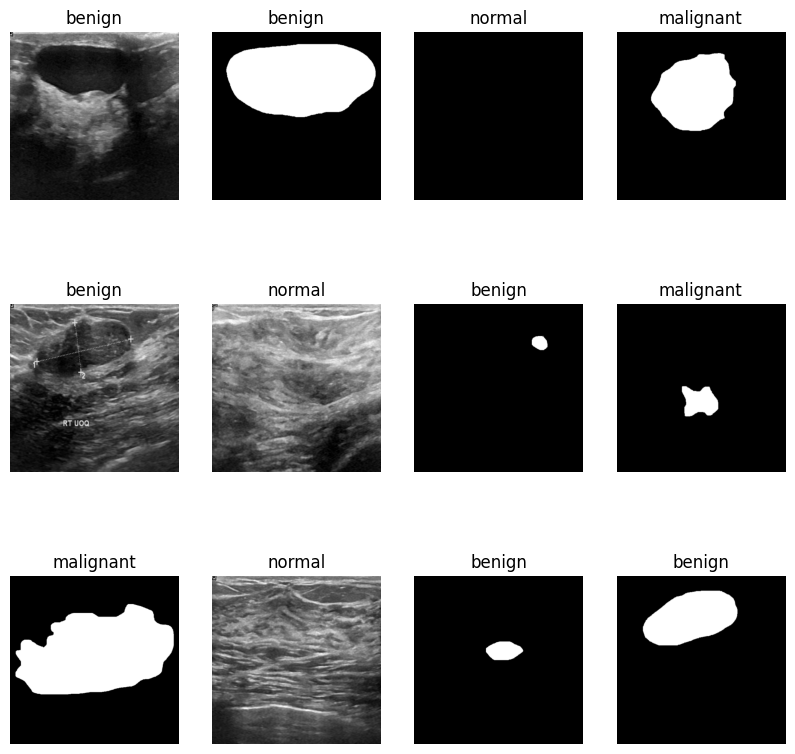

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in Dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Data Preprocessing

In [17]:
image_directory = "D:\\Graduation Project\\Breast Cancer\\archive\\Dataset_BUSI_with_GT/"

def load_images(image_folder, label_value):
    images = [img for img in os.listdir(image_directory + image_folder)]
    for image_name in images:
        if image_name.split('.')[1] == 'png' and '_mask' not in image_name:
            image = cv2.imread(image_directory + image_folder + image_name)
            if image is not None:
                image = Image.fromarray(image, 'RGB')
                image = image.resize((SIZE, SIZE))
                image = np.array(image)
                dataset.append(image)
                label.append(label_value)

SIZE = SIZE
dataset = []
label = []

load_images('benign/', 0)  # Benign class with label 0
load_images('malignant/', 1)  # Malignant class with label 1
load_images('normal/', 2)  # Normal class with label 2
# Convert dataset and label to numpy arrays
dataset = np.array(dataset)
label = np.array(label)
print("Dataset shape:", dataset.shape)
print("Label shape:", label.shape)

Dataset shape: (780, 224, 224, 3)
Label shape: (780,)


# Custom Preprocessing Setting

In [19]:
def custom_preprocessing(image):
    # Apply noise to the image
    noisy_image = add_noise_to_image(image)
    
    # Apply blur to the image
    blurred_image = apply_blur_to_image(noisy_image)
    
    # Adjust contrast and brightness
    enhanced_image = adjust_contrast_brightness(blurred_image)

    return enhanced_image

def add_noise_to_image(image):
    # Add noise to the image (customize this function as needed)
    noisy_image = np.clip(image + np.random.normal(loc=0, scale=0.1, size=image.shape), 0, 1)
    return noisy_image

def apply_blur_to_image(image):
    # Apply blur to the image (customize this function as needed)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    return blurred_image

def adjust_contrast_brightness(image):
    # Adjust contrast and brightness (customize as needed)
    img = (image * 255).astype(np.uint8)  # Convert image to uint8 for PIL
    pil_img = Image.fromarray(img)
    
    enhancer = ImageEnhance.Contrast(pil_img)
    enhanced_img = enhancer.enhance(1.5)  # Increase contrast by a factor of 1.5
    
    enhancer = ImageEnhance.Brightness(enhanced_img)
    enhanced_img = enhancer.enhance(1.2)  # Increase brightness by a factor of 1.2
    
    enhanced_img = np.array(enhanced_img) / 255.0  # Convert back to float32
    
    return enhanced_img

# Splitting the Data to Test and Train and Augmentating the Data 

In [21]:
# Split the dataset into train and test sets
num_samples, height, width, channels = dataset.shape
X_flat = dataset.reshape(num_samples, -1)  # Reshape to (samples, height*width*channels)
X_train, X_test, y_train, y_test = train_test_split(X_flat, label, test_size=0.25, random_state=42)
X_train = X_train.reshape(-1, 224, 224, 3)  # Reshape your input data to match the expected input shape

#Applying different augmentation settings to minority classes:
augmentation_class1 = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=5,  # Rotate images by a maximum of 10 degrees
    width_shift_range=0.1,  # Shift images horizontally by 10% of the width
    height_shift_range=0.1,  # Shift images vertically by 10% of the height
    zoom_range=0.1,  # Zoom images by 10%
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,  # No vertical flipping
    preprocessing_function=custom_preprocessing
)
augmentation_class2 = ImageDataGenerator(
    rotation_range=30,  # Rotate images by a maximum of 10 degrees
    width_shift_range=0.2,  # Shift images horizontally by 10% of the width
    height_shift_range=0.2,  # Shift images vertically by 10% of the height
    zoom_range=0.2,  # Zoom images by 10%
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,
    preprocessing_function=custom_preprocessing

)

#General Augmentation:

datagen = ImageDataGenerator(
    horizontal_flip=True,   # Flip images horizontally
    vertical_flip=True,     # Flip images vertically
    fill_mode='nearest'     # Fill in missing pixels using the nearest available
)

datagen.fit(X_train)
augmented_images = []
augmented_labels = []

# Number of times to augment the data (in this case, we'll double the dataset)
augmentation_factor = 2

for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=len(X_train), shuffle=False):
    augmented_images.append(x_batch)
    augmented_labels.append(y_batch)
    if len(augmented_images) >= augmentation_factor:
        break

# Concatenate the augmented data batches
X_train = np.concatenate(augmented_images)
y_train = np.concatenate(augmented_labels)

# Verify the shape of augmented data
print("Shape of augmented images:", X_train.shape)
print("Shape of augmented labels:", y_train.shape)

def apply_augmentation(X_train, y_train):
    if y_train == 1:  # Check for class 1
        return augmentation_class1.random_transform(X_train), y_train
    if y_train == 2:
        return augmentation_class2.random_transform(X_train), y_train
    else:
        return X_train, y_train
X_test= X_test.reshape(-1, 224, 224, 3)  # Reshape your input data to match the expected input shape

Shape of augmented images: (1170, 224, 224, 3)
Shape of augmented labels: (1170,)


# Defning and Training the Model

In [23]:
# Compute class weights
class_labels = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
# Assign more weight to the second class
class_weights[1] *= 10.0  
class_weights[2] *= 4.0  
# Create a dictionary of class weights
class_weight = {i: weight for i, weight in enumerate(class_weights)}


INPUT_SHAPE = (224, 224, 3)  
inp = keras.layers.Input(shape=INPUT_SHAPE)

In [27]:
model = Sequential()

pretrained_model= keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='max',classes=3,
                   weights='imagenet')


model.add(pretrained_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())  # Batch Normalization layer
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

#pretrained_model.trainable=False
for layer in pretrained_model.layers:
    layer.trainable = False
# Unfreeze the last few layers for fine-tuning(I achieved much better results adding this step)
for layer in pretrained_model.layers[-12:]:
    layer.trainable = True

In [28]:
optimizer= Adam(learning_rate=0.0005) 
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',  
                metrics=['accuracy'])

In [29]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                      

In [30]:
y_train = to_categorical(y_train, num_classes=3)  
y_test = to_categorical(y_test, num_classes=3) 

In [31]:
checkpoint_path = "D:\Graduation Project\Breast Cancer\model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max', 
                             save_weights_only=True)
#Fit the model
history = model.fit(np.array(X_train),
                         y_train,
                         batch_size = BATCH_SIZE,
                         verbose = 1,
                         epochs = EPOCHS,    
                         #validation_split = 0.1,
                         validation_data=(X_test, y_test),
                         shuffle = True,
                         class_weight=class_weight,
                         callbacks=[checkpoint]
                         #callbacks=[reduce_lr]
                     )
                    
                    
model.load_weights(checkpoint_path)

Epoch 1/50


37/37 [==============================] - ETA: 0s - loss: 5.1051 - accuracy: 0.5239
Epoch 1: val_accuracy improved from -inf to 0.64615, saving model to D:\Graduation Project\Breast Cancer\model.keras
37/37 [==============================] - 104s 2s/step - loss: 5.1051 - accuracy: 0.5239 - val_loss: 3.0072 - val_accuracy: 0.6462
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: 2.4230 - accuracy: 0.6239
Epoch 2: val_accuracy improved from 0.64615 to 0.76410, saving model to D:\Graduation Project\Breast Cancer\model.keras
37/37 [==============================] - 73s 2s/step - loss: 2.4230 - accuracy: 0.6239 - val_loss: 1.0795 - val_accuracy: 0.7641
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 1.4412 - accuracy: 0.6795
Epoch 3: val_accuracy did not improve from 0.76410
37/37 [==============================] - 66s 2s/step - loss: 1.4412 - accuracy: 0.6795 - val_loss: 0.9231 - val_accuracy: 0.7231
Epoch 4/50
37/37 [======================

In [ ]:
model.save('model.keras')

In [ ]:
model = keras.models.load_model("D:\Graduation Project\Breast Cancer\model.keras")

# Evaluating the Model

7/7 [==============================] - 8s 1s/step
Test Accuracy: 0.8512820601463318

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       112
           1       0.74      0.88      0.80        51
           2       0.93      0.81      0.87        32

    accuracy                           0.85       195
   macro avg       0.85      0.85      0.85       195
weighted avg       0.86      0.85      0.85       195


Confusion Matrix:


<AxesSubplot: >

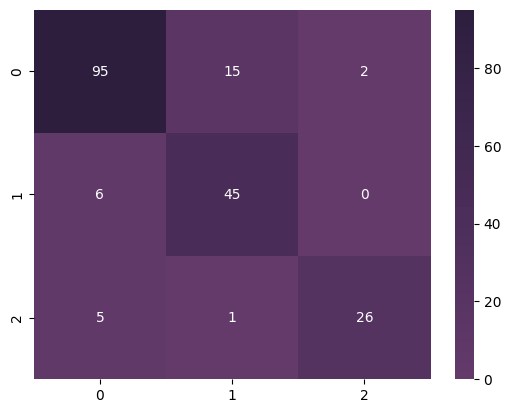

In [36]:
# Evaluate the model on the test set
evaluation = model.evaluate(X_test, y_test, verbose=1)

# Generate predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification report and confusion matrix
print("Test Accuracy:", evaluation[1])
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes))
print("\nConfusion Matrix:")
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
cmap = sns.cubehelix_palette(light=0.3, as_cmap=True)
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap=cmap) 

# Random Result Observation 

1/1 [==============================] - 0s 371ms/step


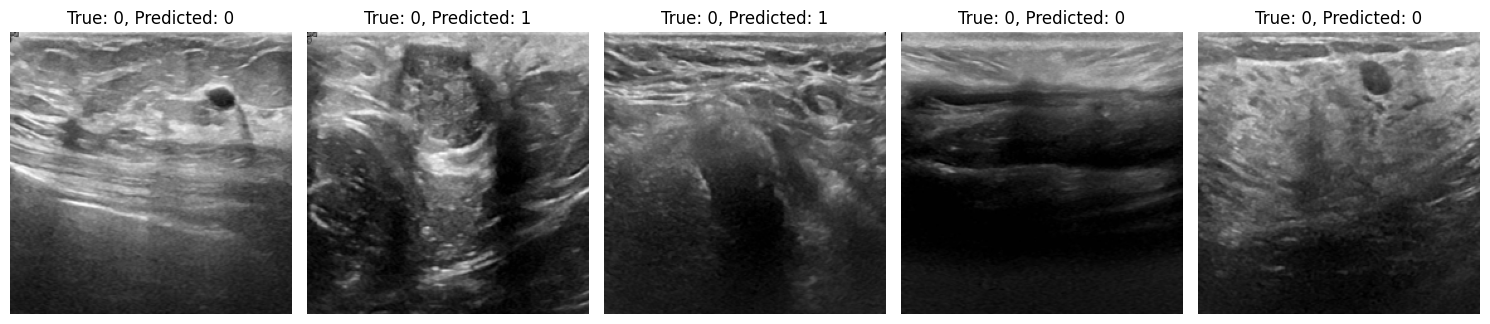

In [37]:
# Get some random indices from the test set
num_samples_to_display = 5  # Number of random samples to display
random_indices = np.random.choice(X_test.shape[0], num_samples_to_display, replace=False)

# Get the corresponding images, ground truth labels, and predicted labels
images_to_display = X_test[random_indices]
true_labels = y_test[random_indices]
predicted_labels = model.predict(images_to_display)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Convert true_labels to integers because they are one-hot encoded
true_labels_int = np.argmax(true_labels, axis=1)

# Display the images along with their ground truth and predicted labels
plt.figure(figsize=(15, 5))
for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(images_to_display[i].reshape(height, width, channels)) 
    plt.title(f"True: {true_labels_int[i]}, Predicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
